In [1]:
# Libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from collections import namedtuple
from time import sleep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Nursery Schools
### Summary
For this project I would like to analyze the similarities and differences between different schools. Some of the important attributes that I believe are important for parents are the following:

1. Admission policy
    - Public
    - Private
2. Location
    - District (Arrondissement)
    - Neighbourhood (Quartier)
3. Through school (Nursery and Elementary)
4. Has catering service
5. Is part of the priority education program (Not part of the program, REP, REP+)
6. Institution specialized areas
    - Arts
    - Cinema
    - Theater
    - Sport
7. Is part of the enhanced language instruction program
    - Section européenne (Exclusively managed by the national education ministry)
    - Section internationale (Have active participation of foreign partners)
8. Number of students and classroom density
9. Institution age in years
10. Housing information of the area
11. Public transportation services of the area
12. Air quality (I was not able to get this dataset)

From this information I am interested in clustering similar schools together, and from a given school find the n number of schools that are most similar.

### Data Sources
I believe most of this information is publicly available through local and federal open data platforms.
1. [Education Directory](https://data.education.gouv.fr/explore/dataset/fr-en-annuaire-education/information/?disjunctive.identifiant_de_l_etablissement&disjunctive.nom_etablissement&disjunctive.type_etablissement&disjunctive.code_postal&disjunctive.code_commune&disjunctive.nom_commune&disjunctive.code_departement&disjunctive.code_academie&disjunctive.appartenance_education_prioritaire&disjunctive.type_contrat_prive&disjunctive.libelle_departement&disjunctive.libelle_academie&disjunctive.libelle_region&disjunctive.nom_circonscription&disjunctive.ministere_tutelle&disjunctive.code_type_contrat_prive&disjunctive.pial&refine.code_region=75&refine.ecole_maternelle=1): Data on open public and private establishments located in France.
    - Administrative institution number (UAI)
    - Institution Name
    - Institution Type
    - Public/Private
    - Zip Code
    - Municipality Code
    - Municipality Name
    - Department Code
    - Academic Code
    - Region Code
    - Is Kindergarten
    - Is Elementary School
    - Has Catering Service
    - Has Lodging Service
    - Has Inclusive Education Unit
    - Has Arts Section
    - Has Cinema Section
    - Has Theater Section
    - Has Sport Section
    - Has International Section
    - Has European Section
    - Is Priority Education Network (REP), or Reinforced Education Network (REP+)
    - SIRET ID
    - Number of Students
    - If private, contract type
    - Department Label
    - Academic Label
    - Region Label
    - Latitude
    - Longitude
    - Institution Opening Date
    - Updated Date
    - Institution Status
    - Institution with Multiple Sites (Multi UAI)
    - Contract Type ID
- [Student & Class Density](https://data.education.gouv.fr/explore/dataset/fr-en-ecoles-effectifs-nb_classes/table/?disjunctive.rentree_scolaire&disjunctive.region_academique&disjunctive.academie&disjunctive.departement&disjunctive.commune&disjunctive.numero_ecole&disjunctive.denomination_principale&disjunctive.patronyme&disjunctive.secteur&disjunctive.code_postal&sort=tri)
- [Housing Data](https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.annee&disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt)
- [Google Maps API](https://github.com/googlemaps/google-maps-services-python)

In [2]:
education_directory_raw = pd.read_csv('./data/paris_opendata/annuaire.csv', sep=';')
housing_data = pd.read_csv('./data/paris_opendata/logement.csv',sep=';')
paris_neighbourhoods = pd.read_csv('./data/paris_opendata/quartier_paris.csv', sep=';')
google_maps_public_transport_data = pd.read_csv('./data/paris_opendata/paris_schools_public_transport_info.csv')
schools_density = pd.read_csv('./data/paris_opendata/effectifs_classes.csv', sep=';')

/var/folders/92/dqj9dff15r1990xbnbpww0gw0000gn/T/ipykernel_13345/2722827788.py:1: DtypeWarning: Columns (8,10,19,20,39,41,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  education_directory_raw = pd.read_csv('./data/paris_opendata/annuaire.csv', sep=';')


## Exploratory Data Analysis

In [3]:
education_directory_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68977 entries, 0 to 68976
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Identifiant_de_l_etablissement        68977 non-null  object 
 1   Nom_etablissement                     68977 non-null  object 
 2   Type_etablissement                    68692 non-null  object 
 3   Statut_public_prive                   66821 non-null  object 
 4   Adresse_1                             68869 non-null  object 
 5   Adresse_2                             6474 non-null   object 
 6   Adresse_3                             56641 non-null  object 
 7   Code postal                           68977 non-null  int64  
 8   Code_commune                          68977 non-null  object 
 9   Nom_commune                           68977 non-null  object 
 10  Code_departement                      68977 non-null  object 
 11  Code_academie  

In [4]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Année                         12800 non-null  int64  
 1   Secteurs géographiques        12800 non-null  int64  
 2   Numéro du quartier            12800 non-null  int64  
 3   Nom du quartier               12800 non-null  object 
 4   Nombre de pièces principales  12800 non-null  int64  
 5   Epoque de construction        12800 non-null  object 
 6   Type de location              12800 non-null  object 
 7   Loyers de référence           12800 non-null  float64
 8   Loyers de référence majorés   12800 non-null  float64
 9   Loyers de référence minorés   12800 non-null  float64
 10  Ville                         12800 non-null  object 
 11  Numéro INSEE du quartier      12800 non-null  int64  
 12  geo_shape                     12800 non-null  object 
 13  g

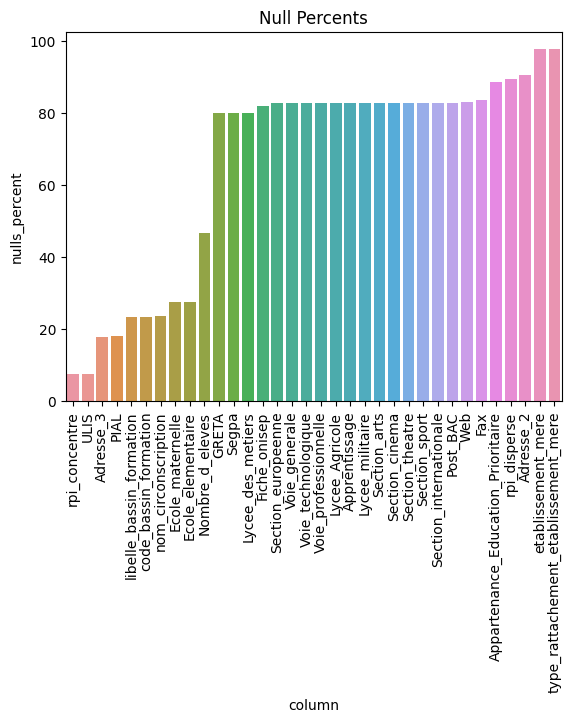

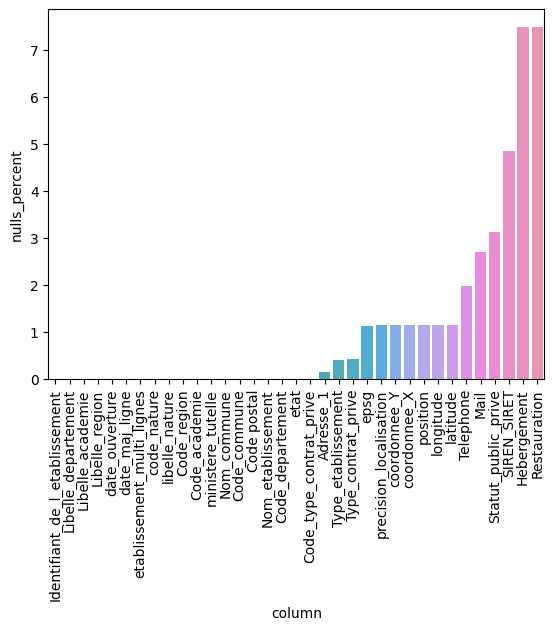

In [5]:
null_pct = education_directory_raw.isna().sum()*100/68977
plt.title('Null Percents')
null_pct = pd.DataFrame({'column':null_pct.index,'nulls_percent':null_pct.values}).sort_values(by='nulls_percent')
sns.barplot(data=null_pct.iloc[-34:,:], x='column',y='nulls_percent')
plt.xticks(rotation=90)
plt.show()
sns.barplot(data=null_pct.iloc[:35,:], x='column',y='nulls_percent')
plt.xticks(rotation=90)
plt.show()

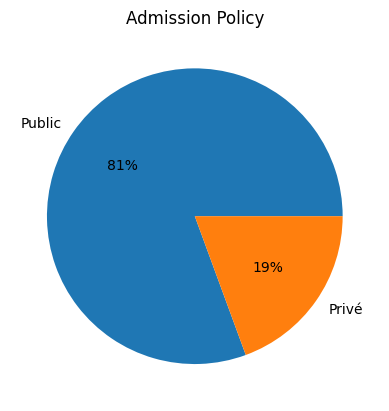

In [6]:
plt.title('Admission Policy')
plt.pie(
    x=education_directory_raw['Statut_public_prive'].value_counts(),
    labels=education_directory_raw['Statut_public_prive'].value_counts().index,
    autopct='%.0f%%',
    
)
plt.show()

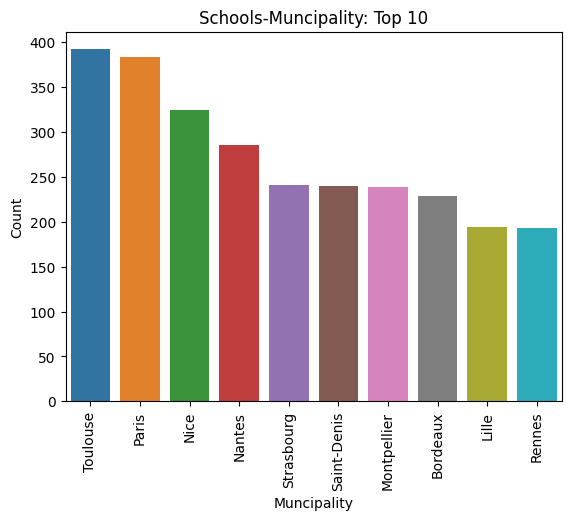

In [7]:
plt.title('Schools-Muncipality: Top 10')
ncom_counts = education_directory_raw['Nom_commune'].value_counts()
ncom_counts = pd.DataFrame({'Muncipality':ncom_counts.index[:10],'Count':ncom_counts.values[:10]})
sns.barplot(data=ncom_counts, x='Muncipality',y='Count', )
plt.xticks(rotation=90)
plt.show()

In [8]:
nursery_types_counts = education_directory_raw[education_directory_raw['libelle_nature'].str.contains('maternelle',case=False)]['libelle_nature'].value_counts()
nursery_types_counts = pd.DataFrame({'Type':nursery_types_counts.index,'Count':nursery_types_counts.values})
nursery_types_counts

,Type,Count
0,ECOLE MATERNELLE,13131
1,ECOLE MATERNELLE D APPLICATION,70
2,ECOLE MATERNELLE ANNEXE D INSPE,1


In [9]:
housing_data.columns

Index(['Année', 'Secteurs géographiques', 'Numéro du quartier',
       'Nom du quartier', 'Nombre de pièces principales',
       'Epoque de construction', 'Type de location', 'Loyers de référence',
       'Loyers de référence majorés', 'Loyers de référence minorés', 'Ville',
       'Numéro INSEE du quartier', 'geo_shape', 'geo_point_2d'],
      dtype='object')

In [10]:
housing_data.sample(3)

,Année,Secteurs géographiques,Numéro du quartier,Nom du quartier,Nombre de pièces principales,Epoque de construction,Type de location,Loyers de référence,Loyers de référence majorés,Loyers de référence minorés,Ville,Numéro INSEE du quartier,geo_shape,geo_point_2d
2915,2021,10,44,Sainte-Marguerite,2,1971-1990,meublé,25.4,30.48,17.78,PARIS,7511144,"{""coordinates"": [[[2.3962365762994087, 48.8541...","48.852096506980004, 2.388764833602562"
66,2020,11,77,Belleville,3,1971-1990,meublé,22.3,26.76,15.61,PARIS,7512077,"{""coordinates"": [[[2.383226691675032, 48.86709...","48.871531200586176, 2.3875492398498026"
8964,2023,1,23,Notre-Dame-des-Champs,2,Avant 1946,meublé,32.9,39.50,23.00,PARIS,7510623,"{""coordinates"": [[[2.336756578897732, 48.84013...","48.84642759400414, 2.3273568782346064"


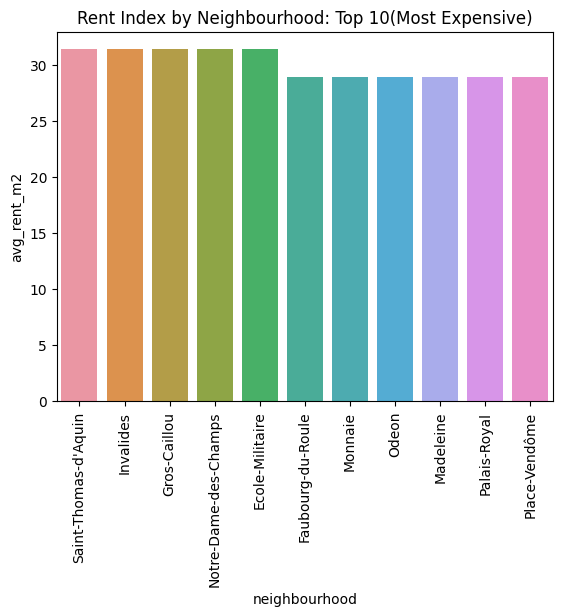

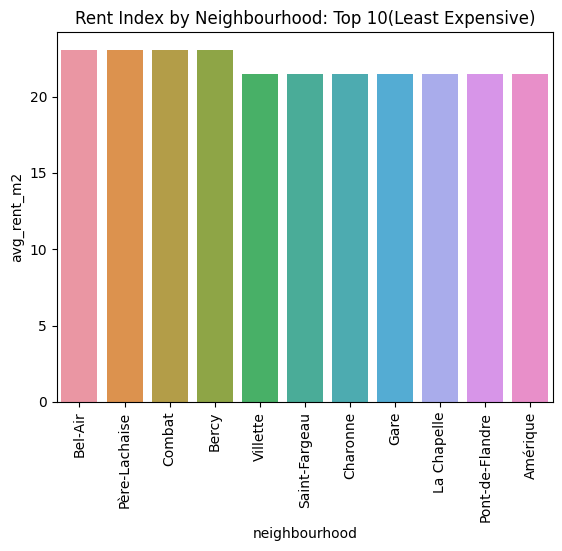

In [11]:
housing_data_2023 = housing_data[housing_data['Année'] == 2023]
rent_index_mean = housing_data_2023[
    ['Nom du quartier','Loyers de référence','Numéro du quartier']
].groupby(
    ['Nom du quartier']
).mean().sort_values(by='Loyers de référence', ascending=False)
rent_index_mean.rename(columns={'Nom du quartier': 'neighbourhood','Numéro du quartier':'neighbourhood_number','Loyers de référence':'rent_index'}, inplace=True)
rent_index_mean_data = pd.DataFrame({
    'neighbourhood': rent_index_mean.index, 
    'avg_rent_m2':rent_index_mean['rent_index'].values 
})
plt.title('Rent Index by Neighbourhood: Top 10(Most Expensive)')
sns.barplot(data=rent_index_mean_data.iloc[:11,:], x='neighbourhood', y='avg_rent_m2')
plt.xticks(rotation=90)
plt.show()
plt.title('Rent Index by Neighbourhood: Top 10(Least Expensive)')
sns.barplot(data=rent_index_mean_data.iloc[-11:,:], x='neighbourhood', y='avg_rent_m2')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Pre Processed Google Data, see code in pre-processing section
google_maps_public_transport_data.sample(5)

,index,name,closest_station_name,distance,id
35,11238,Collège privé Sainte-Louise,Laumière,1.533319,0754007Y
192,44072,Lycée privé Charles de Foucauld,Marx Dormoy,0.246902,0754086J
195,44458,Lycée Lavoisier,Austerlitz,1.969811,0750656F
301,59483,Collège Madame de Staël,Ségur,0.440783,0751563S
44,11568,Section d'enseignement professionnel du lycée ...,Bourse,0.168116,0754874R


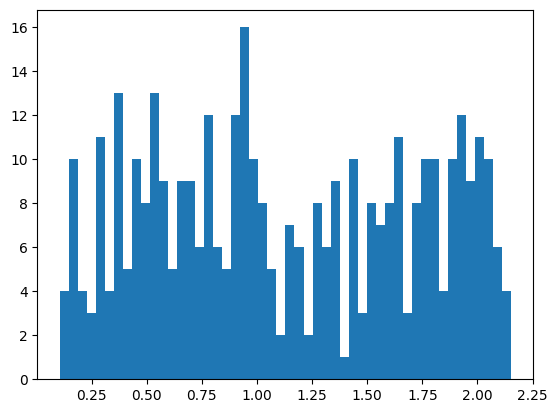

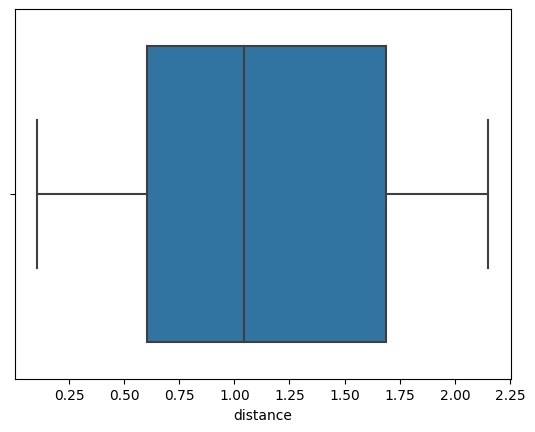

In [13]:
plt.hist(list(google_maps_public_transport_data['distance']), bins=50)
plt.show()
sns.boxplot(x=google_maps_public_transport_data['distance'])
plt.show()

In [14]:
schools_density.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194898 entries, 0 to 194897
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   Rentrée scolaire                              194898 non-null  int64 
 1   Région académique                             194898 non-null  object
 2   Académie                                      194898 non-null  object
 3   Département                                   194898 non-null  object
 4   Commune                                       194898 non-null  object
 5   Numéro de l'école                             194898 non-null  object
 6   Dénomination principale                       194897 non-null  object
 7   Patronyme                                     148531 non-null  object
 8   Secteur                                       194898 non-null  object
 9   REP                                           194898 non-nu

In [15]:
schools_density.sample(3)

,Rentrée scolaire,Région académique,Académie,Département,Commune,Numéro de l'école,Dénomination principale,Patronyme,Secteur,REP,...,Nombre d'élèves en pré-élémentaire hors ULIS,Nombre d'élèves en élémentaire hors ULIS,Nombre d'élèves en ULIS,Nombre d'élèves en CP hors ULIS,Nombre d'élèves en CE1 hors ULIS,Nombre d'élèves en CE2 hors ULIS,Nombre d'élèves en CM1 hors ULIS,Nombre d'élèves en CM2 hors ULIS,tri,Code Postal
178376,2019,NORMANDIE,ROUEN,EURE,PACY-SUR-EURE,0271281W,ECOLE MATERNELLE PUBLIQUE,LES HERONS PACY/EURE,PUBLIC,0,...,80,0,0,0,0,0,0,0,81-NORMANDIE-ROUEN-EURE-PACY-SUR-EURE-0271281W,27120
84014,2021,NOUVELLE-AQUITAINE,BORDEAUX,PYRENEES-ATLANTIQUES,LAHOURCADE,0640936V,ECOLE ELEMENTAIRE PUBLIQUE,NaN,PUBLIC,0,...,17,22,0,2,7,3,5,5,79-NOUVELLE-AQUITAINE-BORDEAUX-PYRENEES-ATLANT...,64150
35318,2022,NOUVELLE-AQUITAINE,BORDEAUX,PYRENEES-ATLANTIQUES,BEYRIE-SUR-JOYEUSE,0640811J,ECOLE ELEMENTAIRE PUBLIQUE,NaN,PUBLIC,0,...,14,32,0,8,10,3,6,5,78-NOUVELLE-AQUITAINE-BORDEAUX-PYRENEES-ATLANT...,64120


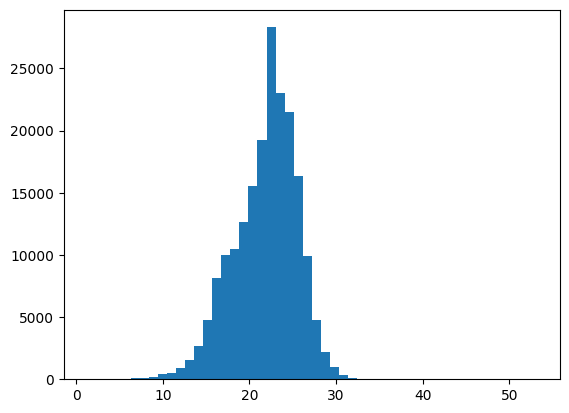

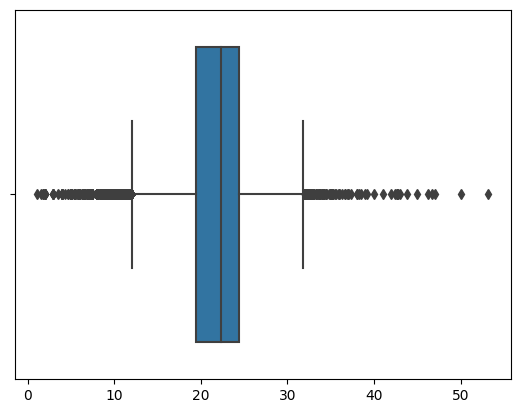

In [16]:
# Student Density = Total number of students/Classes
plt.hist(list(schools_density["Nombre total d'élèves"]/schools_density['Nombre total de classes']), bins=50)
plt.show()
sns.boxplot(x=list(schools_density["Nombre total d'élèves"]/schools_density['Nombre total de classes']))
plt.show()

## Data Pre-Processing

In [17]:
#CONSTANTS
GOOGLE_MAPS_ENDPOINT = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?'
G_API_KEY = None

with open('./api_keys/keys.json','r') as file:
    G_API_KEY = json.loads(file.read())['g']

#HELPERS
def get_distance(lat_long_a: tuple, lat_long_b: tuple):
        return geodesic(lat_long_a, lat_long_b).km

#CLASSES
class Station:
    def __init__(self, name, lat, long, radius=5000):
        self.name = name
        self.lat = lat
        self.long = long
        self.radius = radius
        self.stations = None
        self.closest_station = None
        self.closest_station_name = None
        self.closest_distance = None
        self.call_google()
        
    
    
    def call_google(self):
        url = f'{GOOGLE_MAPS_ENDPOINT}location={self.lat}%2C{self.long}&radius={self.radius}&type=subway_station&type=train_station&key={G_API_KEY}'
        payload={}
        headers = {}
        response = json.loads(requests.request("GET", url, headers=headers, data=payload).text)
        self.stations = response['results']
        if (len(self.stations)):
            try:
                self.closest_station = self.stations[0]
                location = self.closest_station['geometry']['location']
                self.closest_distance = get_distance((self.lat, self.long),(location['lat'], location['lng']))
                self.closest_station_name = self.stations[0]['name']
            except Exception as e:
                print(f'Error getting dictance {e}')
# Filter Paris Region, School Types
class Drop_Columns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop: list = None) -> None:
        self.X = None
        self.y = None
        self.columns_to_drop = columns_to_drop

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.drop(columns=self.columns_to_drop) if self.columns_to_drop else self.X

class Rename_Columns(BaseEstimator, TransformerMixin):
    def __init__(self, column_name_map: dict = None) -> None:
        self.X = None
        self.y = None
        self.column_name_map = column_name_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.rename(columns=self.column_name_map) if self.column_name_map else self.X

class Set_Data_Types(BaseEstimator, TransformerMixin):
    def __init__(self, column_type_map) -> None:
        self.X = None
        self.y = None
        self.column_type_map = column_type_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.astype(self.column_type_map) if self.column_type_map else self.X

class DF_Filter(BaseEstimator, TransformerMixin):
    def __init__(self, statement: str) -> None:
        self.X = None
        self.y = None
        self.statement = statement

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self
    
    def transform(self, X: pd.DataFrame)->pd.DataFrame:
        return X.query(self.statement)
    
class DF_Fill_NA(BaseEstimator, TransformerMixin):
    def __init__(self, column: str, value) -> None:
        self.X = None
        self.y = None
        self.column = column
        self.value = value

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self
    
    def transform(self, X: pd.DataFrame)->pd.DataFrame:
        X[self.column] = X[self.column].fillna(self.value)
        return X

class Replace_Column_Values(BaseEstimator, TransformerMixin):
    def __init__(self, column: str, value_map: dict) -> None:
        self.X = None
        self.y = None
        self.column = column
        self.value_map = value_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self
    
    def transform(self, X: pd.DataFrame)->pd.DataFrame:
        X[self.column] = X[self.column].replace(to_replace=self.value_map)
        return X

class Basic_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop: list = None, column_name_map: dict = None, column_type_map: dict = None) -> None:
        self.X = None
        self.y = None
        self.columns_to_drop = columns_to_drop
        self.column_name_map = column_name_map
        self.column_type_map = column_type_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return Pipeline([
            ('drop_columns', Drop_Columns(self.columns_to_drop)),
            ('rename_columns', Rename_Columns(self.column_name_map)),
            ('set_data_types', Set_Data_Types(self.column_type_map))
        ]).fit_transform(X=self.X, y=self.y)


I will focus my analysis to the area of Paris, since it is my main interest.

In [18]:
education_directory_paris = education_directory_raw[education_directory_raw['Nom_commune'] == 'Paris']
education_directory_paris.sample(3)

,Identifiant_de_l_etablissement,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,...,rpi_concentre,rpi_disperse,code_nature,libelle_nature,Code_type_contrat_prive,PIAL,etablissement_mere,type_rattachement_etablissement_mere,code_bassin_formation,libelle_bassin_formation
25771,0754253R,Collège Saint-Exupéry,Collège,Public,89 boulevard Arago,NaN,NaN,75014,75100,Paris,...,0.0,NaN,340,COLLEGE,99.0,0750445B,NaN,NaN,01000,BASSIN PARIS
11316,0752538B,Collège Rodin,Collège,Public,19 rue Corvisart,NaN,NaN,75013,75100,Paris,...,0.0,NaN,340,COLLEGE,99,0750525N,NaN,NaN,01000,BASSIN PARIS
12328,0751705W,Collège Alphonse Daudet,Collège,Public,93 rue d'Alésia,NaN,NaN,75014,75100,Paris,...,0.0,NaN,340,COLLEGE,99,0750611G,NaN,NaN,01000,BASSIN PARIS


#### Assigning Quartier to Paris Schools
We will need to join the housing data with the education directory data as part of pre-processing. Since we don't have a direct relation between the two dataframes we will need to calculate if the latitudes and longitudes of each school (in Paris) is within the polygons in the paris neighbourhoods data set, and insert this information to the education directory dataframe using the shapely package.

In [19]:
school_quartier_pointer = namedtuple("SchoolPointer", "school_idx quartier_idx")
paris_neighbourhoods_geometry = paris_neighbourhoods[['Geometry']]['Geometry'].apply(lambda c: np.array(json.loads(c)['coordinates'][0]))
paris_neighbourhoods_polygons = [Polygon(np.array([polygons.T[1],polygons.T[0]]).T) for polygons in paris_neighbourhoods_geometry]

paris_schools_geolocation = education_directory_raw[education_directory_raw['Nom_commune']=='Paris'].iloc[:,51:53]
paris_schools_points = [Point(lat, long) for (lat,long) in np.array(paris_schools_geolocation)]
paris_schools_index = education_directory_raw[education_directory_raw['Nom_commune']=='Paris'].index
paris_neighbourhoods_index = paris_neighbourhoods.index

paris_schools_quartiers_pointers = []
for idx_point, point in enumerate(paris_schools_points):
    for idx_polygon, polygon in enumerate(paris_neighbourhoods_polygons):
        is_within = point.within(polygon)
        if(is_within):
            paris_schools_quartiers_pointers.append(school_quartier_pointer(paris_schools_index[idx_point], paris_neighbourhoods_index[idx_polygon]))
paris_schools_quartiers_pointers[0:5]


[SchoolPointer(school_idx=10108, quartier_idx=39),
 SchoolPointer(school_idx=10132, quartier_idx=4),
 SchoolPointer(school_idx=10143, quartier_idx=26),
 SchoolPointer(school_idx=10322, quartier_idx=20),
 SchoolPointer(school_idx=10330, quartier_idx=64)]

#### Public Transport Options of the Area

We will use the Google Maps API to get the nearest subway or train station in KM to each Paris' school in the education directory.
The code in this section is commented, so we don't call Google's API's on every notebook run, but the data is saved as csv.

In [20]:
school_geo_location = namedtuple('Geolocation','name lat long')
schools_public_transport_info = []
schools_geolocs = [school_geo_location(school[0], school[1], school[2]) for school in list(education_directory_paris[['Nom_etablissement','latitude','longitude']].values)]
for school in schools_geolocs:
    try:
        #station = Station(school.name, school.lat, school.long)
        #schools_public_transport_info.append(station)
        pass
    except Exception as e:
        print(e)

In [21]:
#schools_public_transport_summary = pd.DataFrame(
#    [np.array([s.name, s.closest_station_name, s.closest_distance]) for s in schools_public_transport_info], 
#    columns=['name', 'closest_station_name','distance'],
#    index = education_directory_paris.index
#)
#schools_public_transport_summary['id'] = list(education_directory_paris['Identifiant_de_l_etablissement'].values)
#schools_public_transport_summary
#schools_public_transport_summary.to_csv('./data/paris_opendata/paris_schools_public_transport_info.csv')
google_maps_public_transport_data.sample(5)

,index,name,closest_station_name,distance,id
174,42714,Lycée privé de l'Assomption,Kléber,0.534434,0753948J
180,42923,Lycée Jules Siegfried,Gare du Nord,0.448808,0750674A
14,10333,Collège privé Soeur Rosalie,Austerlitz,0.733082,0753967E
283,59417,Collège Victor Duruy,Ségur,0.798483,0752528R
158,26815,Centre d'information et d'orientation d'État P...,Porte de Montreuil,1.917586,0753312T


In [22]:
public_transport_data = google_maps_public_transport_data.copy()
public_transport_data.set_index(inplace=True, keys=['index'])
df = education_directory_paris.join(public_transport_data, how='inner')
paris_schools_neighbourhoods = pd.DataFrame(
    [tuple(paris_neighbourhoods.iloc[s.quartier_idx,:][['C_QU','L_QU']].values) for s in paris_schools_quartiers_pointers], 
    columns=['neighbourhood_number','neighbourhood_name'],
    index=[s.school_idx for s in paris_schools_quartiers_pointers]
)
df = df.join(paris_schools_neighbourhoods, how='inner')
df = pd.merge(df, rent_index_mean, on='neighbourhood_number', how='inner')
df

,Identifiant_de_l_etablissement,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,...,type_rattachement_etablissement_mere,code_bassin_formation,libelle_bassin_formation,name,closest_station_name,distance,id,neighbourhood_number,neighbourhood_name,rent_index
0,0750673Z,Lycée Colbert,Lycée,Public,27 rue Château Landon,NaN,NaN,75010,75100,Paris,...,NaN,01000,BASSIN PARIS,Lycée Roger Verlomme,Ségur,1.044213,0750696Z,37,Saint-Vincent-de-Paul,26.237500
1,0752923V,Collège privé Rocroy Saint-Vincent de Paul,Collège,Privé,106 rue du faubourg Poissonnière,NaN,NaN,75010,75100,Paris,...,NaN,01000,BASSIN PARIS,Lycée privé Sainte-Jeanne Elisabeth,Ségur,0.538646,0753852E,37,Saint-Vincent-de-Paul,26.237500
2,0753825A,Lycée privé Morvan,Lycée,Privé,68 rue de la Chaussée d'Antin,NaN,NaN,75009,75100,Paris,...,NaN,01000,BASSIN PARIS,Collège privé Saint-Michel de Picpus,Porte de Montreuil,1.621375,0752934G,34,Chaussée-d'Antin,28.956250
3,0752916M,Collège privé Morvan,Collège,Privé,68 rue de la Chaussée d'Antin,NaN,NaN,75009,75100,Paris,...,NaN,01000,BASSIN PARIS,Collège privé Morvan,Opéra,0.566841,0752916M,34,Chaussée-d'Antin,28.956250
4,0753217P,Lycée technologique privé Sainte-Thérèse Appre...,Lycée,Privé,40 rue Jean de La Fontaine,NaN,NaN,75016,75100,Paris,...,NaN,01000,BASSIN PARIS,LP métiers de l'ameublement,Austerlitz,1.945068,0750784V,61,Auteuil,26.271875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0752608C,Lycée professionnel hôtelier Belliard,Lycée,Public,135 rue Belliard,NaN,NaN,75018,75100,Paris,...,NaN,01000,BASSIN PARIS,Lycée professionnel hôtelier Belliard,Porte de Saint-Ouen,0.420220,0752608C,69,Grandes-Carrières,24.121875
134,0752190Y,Collège Guillaume Apollinaire,Collège,Public,39 avenue Emile Zola,NaN,NaN,75015,75100,Paris,...,NaN,01000,BASSIN PARIS,Collège Guillaume Apollinaire,Ségur,1.836879,0752190Y,60,Javel,26.271875
135,0752195D,Collège Gérard Philipe,Collège,Public,8 rue des Amiraux,NaN,NaN,75018,75100,Paris,...,NaN,01000,BASSIN PARIS,Collège Gérard Philipe,Simplon,0.305225,0752195D,70,Clignancourt,24.121875
136,0752196E,Collège Marx Dormoy,Collège,Public,55 rue Marx Dormoy,NaN,NaN,75018,75100,Paris,...,NaN,01000,BASSIN PARIS,Collège Marx Dormoy,Gare du Nord,0.898933,0752196E,71,Goutte-d'Or,24.637500
